In [ ]:
# interpretability/visualizer.py
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Union
import torch
import pandas as pd
import json
# Core module for handling latent concept learning and demonstration selection
from dataclasses import dataclass
import torch
import torch.nn as nn
from typing import List, Dict, Optional, Tuple, Union
from transformers import AutoModelForCausalLM, AutoTokenizer

class ConceptTokenVisualizer:
    """
    Visualizes learned concept tokens and their relationships
    Maps to Figure 5 in the paper
    """
    def __init__(self, concept_learner):
        self.concept_learner = concept_learner
        self.tsne = TSNE(n_components=2, random_state=42)
        
    def plot_concept_embeddings(self, tasks: List[str], save_path: Optional[str] = None):
        """
        Create t-SNE visualization of concept token embeddings
        Similar to Figure 5 in the paper
        """
        # Get embeddings for all concept tokens
        embeddings = []
        labels = []
        
        # Extract concept token embeddings
        embedding_matrix = self.concept_learner.model.get_input_embeddings().weight
        
        for task in tasks:
            token_ids = self._get_concept_token_ids(task)
            task_embeddings = embedding_matrix[token_ids].detach().cpu().numpy()
            embeddings.append(task_embeddings)
            labels.extend([task] * len(token_ids))
            
        embeddings = np.vstack(embeddings)
        
        # Compute t-SNE
        tsne_result = self.tsne.fit_transform(embeddings)
        
        # Plot
        plt.figure(figsize=(10, 10))
        sns.scatterplot(
            x=tsne_result[:, 0], 
            y=tsne_result[:, 1],
            hue=labels,
            style=labels,
            s=100
        )
        plt.title("t-SNE Visualization of Concept Token Embeddings")
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def find_similar_tokens(self, task: str, top_k: int = 10) -> List[Dict]:
        """
        Find most similar vocabulary tokens to concept tokens
        Maps to Table 13 in the paper
        """
        concept_embeds = self._get_concept_embeddings(task)
        vocab_embeds = self.concept_learner.model.get_input_embeddings().weight
        
        # Compute cosine similarity
        similarities = torch.nn.functional.cosine_similarity(
            concept_embeds.unsqueeze(1),
            vocab_embeds.unsqueeze(0),
            dim=2
        )
        
        # Get top-k similar tokens for each concept token
        top_k_values, top_k_indices = torch.topk(similarities, k=top_k, dim=1)
        
        results = []
        for i, (values, indices) in enumerate(zip(top_k_values, top_k_indices)):
            similar_tokens = [
                self.concept_learner.tokenizer.decode(idx.item())
                for idx in indices
            ]
            results.append({
                'concept_token': f"{task}_token_{i}",
                'similar_tokens': similar_tokens,
                'similarities': values.tolist()
            })
            
        return results

class DemonstrationAnalyzer:
    """
    Analyzes selected demonstrations and their properties
    """
    def __init__(self, demonstration_selector):
        self.selector = demonstration_selector
        
    def plot_score_distribution(self, candidates: List[Dict], task: str):
        """
        Plot histogram of concept token prediction scores
        Maps to Figure 10 in the paper
        """
        scores = []
        for candidate in candidates:
            if candidate['task'] == task:
                score = self.selector._compute_concept_score(candidate)
                scores.append(score)
                
        plt.figure(figsize=(10, 6))
        plt.hist(scores, bins=30)
        plt.title(f"Distribution of Concept Scores for {task}")
        plt.xlabel("Score")
        plt.ylabel("Count")
        plt.show()
        
    def analyze_demonstration_diversity(self, demonstrations: List[Dict]):
        """
        Analyze diversity of selected demonstrations
        """
        # Compute embeddings for demonstrations
        embeddings = self._get_demonstration_embeddings(demonstrations)
        
        # Compute pairwise cosine similarities
        similarities = torch.nn.functional.cosine_similarity(
            embeddings.unsqueeze(1),
            embeddings.unsqueeze(0)
        )
        
        return {
            'mean_similarity': similarities.mean().item(),
            'min_similarity': similarities.min().item(),
            'max_similarity': similarities.max().item()
        }

class PerformanceAnalyzer:
    """
    Analyzes model performance and ablation studies
    """
    def __init__(self):
        self.metrics = defaultdict(list)
        
    def log_experiment(
        self,
        experiment_name: str,
        accuracy: float,
        parameters: Dict
    ):
        """Log experimental results"""
        self.metrics[experiment_name].append({
            'accuracy': accuracy,
            'parameters': parameters
        })
        
    def plot_ablation_study(
        self, 
        parameter: str,
        experiments: List[str]
    ):
        """
        Create ablation study plots
        Maps to Figure 4 in the paper
        """
        data = []
        for exp in experiments:
            for result in self.metrics[exp]:
                data.append({
                    'parameter_value': result['parameters'][parameter],
                    'accuracy': result['accuracy'],
                    'experiment': exp
                })
                
        df = pd.DataFrame(data)
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=df, 
            x='parameter_value',
            y='accuracy',
            hue='experiment'
        )
        plt.title(f"Ablation Study: Effect of {parameter}")
        plt.show()
        
    def compare_causal_directions(
        self,
        tasks: List[str],
        results_xy: Dict[str, float],
        results_yx: Dict[str, float]
    ):
        """
        Compare performance between causal directions
        Maps to Figure 6 in the paper
        """
        df = pd.DataFrame({
            'task': tasks * 2,
            'accuracy': list(results_xy.values()) + list(results_yx.values()),
            'direction': ['X->Y'] * len(tasks) + ['Y->X'] * len(tasks)
        })
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df, x='task', y='accuracy', hue='direction')
        plt.title("Performance Comparison: Causal Directions")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()





@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    max_length: int = 1024
    max_length_per_example: int = 256
    learning_rate: float = 1e-4
    batch_size: int = 16
    num_train_steps: int = 10000

class ConceptLearner:
    """
    Handles latent concept learning phase (Phase 1 from paper)
    """
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(config.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        
    def add_concept_tokens(self, tasks: List[str]) -> None:
        """Add new concept tokens for each task"""
        new_tokens = []
        for task in tasks:
            for i in range(self.config.n_prefix_tokens):
                new_tokens.append(f"<{task}_token_{i}>")
        
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))
        
        # Freeze all parameters except new token embeddings
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.get_input_embeddings().weight.requires_grad = True

    def train(self, train_data: List[Dict], task_direction: str = "X->Y") -> None:
        """Train concept tokens"""
        optimizer = torch.optim.Adam(
            [p for p in self.model.parameters() if p.requires_grad],
            lr=self.config.learning_rate
        )
        
        for step in range(self.config.num_train_steps):
            batch = self._get_batch(train_data)
            loss = self._compute_loss(batch, task_direction)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

class DemonstrationSelector:
    """
    Handles demonstration selection phase (Phase 2 from paper)
    """
    def __init__(self, concept_learner: ConceptLearner):
        self.concept_learner = concept_learner
        
    def select_demonstrations(
        self, 
        candidates: List[Dict],
        k: int = 4,
        task_direction: str = "X->Y"
    ) -> List[Dict]:
        """Select top-k demonstrations based on concept token prediction probability"""
        scores = []
        
        for candidate in candidates:
            score = self._compute_concept_score(candidate, task_direction)
            scores.append((score, candidate))
            
        # Select top-k demonstrations
        scores.sort(reverse=True)
        return [candidate for _, candidate in scores[:k]]

    def _compute_concept_score(self, candidate: Dict, task_direction: str) -> float:
        """Compute probability of predicting concept tokens"""
        if task_direction == "X->Y":
            input_text = candidate["input"]
            target_text = candidate["output"]
        else:  # Y->X
            input_text = candidate["output"]
            target_text = candidate["input"]
            
        inputs = self.concept_learner.tokenizer(
            input_text,
            return_tensors="pt"
        )
        
        with torch.no_grad():
            outputs = self.concept_learner.model(**inputs)
            
        # Compute probability of concept tokens
        concept_token_ids = self._get_concept_token_ids(candidate["task"])
        probs = torch.softmax(outputs.logits[:, -1], dim=-1)
        score = probs[:, concept_token_ids].mean().item()
        
        return score


class MetaICL:
    """
    Main class combining core functionality and analysis capabilities
    """
    def __init__(self, config: ModelConfig):
        # Core components
        self.concept_learner = ConceptLearner(config)
        self.demonstration_selector = DemonstrationSelector(self.concept_learner)
        
        # Analysis components
        self.concept_visualizer = ConceptTokenVisualizer(self.concept_learner)
        self.demo_analyzer = DemonstrationAnalyzer(self.demonstration_selector)
        self.performance_analyzer = PerformanceAnalyzer()

    def train(self, train_data: List[Dict], task_direction: str = "X->Y") -> None:
        """Train concept tokens"""
        tasks = list(set(x["task"] for x in train_data))
        self.concept_learner.add_concept_tokens(tasks)
        self.concept_learner.train(train_data, task_direction)
        
    def select_demonstrations(
        self,
        candidates: List[Dict],
        k: int = 4,
        task_direction: str = "X->Y"
    ) -> List[Dict]:
        """Select demonstrations"""
        return self.demonstration_selector.select_demonstrations(
            candidates,
            k,
            task_direction
        )
        
    def do_inference(
        self,
        test_input: str,
        demonstrations: List[Dict],
        target_model: Optional[str] = None
    ) -> str:
        """Perform in-context learning inference"""
        if target_model:
            model = AutoModelForCausalLM.from_pretrained(target_model)
            tokenizer = AutoTokenizer.from_pretrained(target_model)
        else:
            model = self.concept_learner.model
            tokenizer = self.concept_learner.tokenizer
            
        prompt = self._format_prompt(test_input, demonstrations)
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model.generate(**inputs)
        
        return tokenizer.decode(outputs[0])

    # Analysis methods
    def analyze_concept_tokens(self, tasks: List[str], save_path: Optional[str] = None):
        """Analyze learned concept tokens"""
        self.concept_visualizer.plot_concept_embeddings(tasks, save_path)
        return self.concept_visualizer.find_similar_tokens(tasks)
                
    def analyze_demonstrations(self, candidates: List[Dict], task: str):
        """Analyze demonstration selection"""
        scores = self.demo_analyzer.plot_score_distribution(candidates, task)
        demonstrations = self.select_demonstrations(candidates)
        diversity = self.demo_analyzer.analyze_demonstration_diversity(demonstrations)
        
        return {
            'scores': scores,
            'diversity_metrics': diversity,
            'selected_demonstrations': demonstrations
        }

    def log_experiment(self, name: str, accuracy: float, params: Dict):
        """Log experimental results"""
        self.performance_analyzer.log_experiment(name, accuracy, params)

    def plot_ablation_study(self, parameter: str, experiments: List[str]):
        """Generate ablation study visualization"""
        return self.performance_analyzer.plot_ablation_study(parameter, experiments)

    def _format_prompt(self, input_text: str, demonstrations: List[Dict]) -> str:
        """Helper method to format prompt with demonstrations"""
        prompt = ""
        for demo in demonstrations:
            prompt += f"{demo['input']} {demo['output']}\n\n"
        prompt += input_text
        return prompt

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from dataclasses import dataclass
import torch
from typing import List, Dict, Optional, Tuple, Union

class ConceptTokenVisualizer:
    def __init__(self, concept_learner):
        self.concept_learner = concept_learner

    def plot_token_contributions(self, input_text: str, task: str):
        """
        Visualize token contributions using attention weights
        """
        inputs = self.concept_learner.tokenizer(input_text, return_tensors="pt")
        outputs = self.concept_learner.model(**inputs, output_attentions=True)

        # Average over heads and remove batch dimension
        attention_scores = outputs.attentions[-1].mean(dim=1).squeeze(0).detach().cpu().numpy()

        # Use the last layer and take mean attention scores for tokens
        token_attention_scores = attention_scores.mean(axis=0)

        # Tokens must be aligned with attention scores
        tokens = self.concept_learner.tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))

        plt.figure(figsize=(15, 5))
        sns.barplot(x=tokens, y=token_attention_scores)
        plt.xticks(rotation=45)
        plt.title(f"Token Contributions for Task: {task}")
        plt.xlabel("Tokens")
        plt.ylabel("Attention Score")
        plt.show()


    def plot_concept_embeddings(self, tasks: List[str]):
        """
        Visualize concept token embeddings for multiple tasks using t-SNE
        """
        embeddings = []
        labels = []

        embedding_matrix = self.concept_learner.model.get_input_embeddings().weight
        for task in tasks:
            token_ids = self._get_concept_token_ids(task)
            task_embeddings = embedding_matrix[token_ids].detach().cpu().numpy()
            embeddings.append(task_embeddings)
            labels.extend([task] * len(token_ids))

        embeddings = np.vstack(embeddings)
        n_samples = embeddings.shape[0]
        perplexity = min(30, n_samples - 1)

        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_result = tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 10))
        sns.scatterplot(
            x=tsne_result[:, 0],
            y=tsne_result[:, 1],
            hue=labels,
            style=labels,
            s=100,
            palette="tab10"
        )
        plt.title("t-SNE Visualization of Learned Concept Token Embeddings")
        plt.xlabel("t-SNE Dim 1")
        plt.ylabel("t-SNE Dim 2")
        plt.legend(title="Tasks")
        plt.show()

    def _get_concept_token_ids(self, task: str):
        """
        Helper function to retrieve concept token IDs for a specific task
        """
        return [
            self.concept_learner.tokenizer.convert_tokens_to_ids(f"<{task}_token_{i}>")
            for i in range(self.concept_learner.config.n_prefix_tokens)
        ]


@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4

class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(config.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)

    def add_concept_tokens(self, tasks: List[str]):
        """
        Add new concept tokens for each task
        """
        new_tokens = [f"<{task}_token_{i}>" for task in tasks for i in range(self.config.n_prefix_tokens)]
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))

    def train(self, train_data: List[Dict]):
        """
        Fine-tune the model with task-specific data and concept tokens
        """
        optimizer = torch.optim.Adam(
            [self.model.get_input_embeddings().weight],
            lr=self.config.learning_rate
        )
        for step, batch in enumerate(train_data):
            inputs = self.tokenizer(batch["input"], return_tensors="pt")
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


class DemonstrationSelector:
    def __init__(self, concept_learner: ConceptLearner):
        self.concept_learner = concept_learner

    def select_demonstrations(self, candidates: List[Dict], k: int):
        """
        Select top-k demonstrations
        """
        scores = [(self._compute_concept_score(c), c) for c in candidates]
        scores.sort(reverse=True, key=lambda x: x[0])
        return [c for _, c in scores[:k]]

    def _compute_concept_score(self, candidate: Dict):
        """
        Compute demonstration relevance score P_M(theta | X, Y)
        """
        inputs = self.concept_learner.tokenizer(candidate["input"], return_tensors="pt")
        outputs = self.concept_learner.model(**inputs)
        logits = outputs.logits[:, -1, :]  # Logits for the last token

        # Tokenize the target output
        target_ids = self.concept_learner.tokenizer(candidate["output"], return_tensors="pt")["input_ids"].squeeze(0)

        # Handle multiple target tokens
        probs = torch.softmax(logits, dim=-1)
        scores = [probs[0, target_id].item() for target_id in target_ids]
        return np.mean(scores)  # Return the average score for all target tokens


    def plot_relevance_scores(self, candidates: List[Dict], k: int):
        """
        Plot relevance scores for selected demonstrations
        """
        selected = self.select_demonstrations(candidates, k)
        scores = [self._compute_concept_score(c) for c in selected]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=[f"Demo {i+1}" for i in range(k)], y=scores)
        plt.title("Relevance Scores for Selected Demonstrations")
        plt.xlabel("Demonstration")
        plt.ylabel("Relevance Score")
        plt.show()

class MetaICL:
    """
    Main class combining core functionality and explanations
    """
    def __init__(self, config: ModelConfig):
        self.concept_learner = ConceptLearner(config)
        self.visualizer = ConceptTokenVisualizer(self.concept_learner)
        self.selector = DemonstrationSelector(self.concept_learner)

    def train(self, train_data: List[Dict], tasks: List[str]):
        """
        Train the model and add concept tokens
        """
        self.concept_learner.add_concept_tokens(tasks)
        self.concept_learner.train(train_data)

    def explain(self, input_text: str, candidates: List[Dict], task: str, k: int):
        """
        Provide explanations for a task
        """
        print("Visualizing token contributions...")
        self.visualizer.plot_token_contributions(input_text, task)

        print("Analyzing demonstration relevance...")
        self.selector.plot_relevance_scores(candidates, k)



        
from IPython.display import HTML, display
from jinja2 import Template

def create_token_visualization(samples_with_scores, prompt_text):
    """
    Create an interactive HTML visualization for token scores and display it inline in Jupyter.
    """
    html_template = '''
    <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
        <style>
            .token-container {
                margin: 10px 0;
                padding: 10px;
                border: 1px solid #ddd;
                border-radius: 8px;
            }
            .token {
                display: inline-block;
                margin: 1px; /* Reduce margin between tokens */
                padding: 2px 5px; /* Compact padding inside tokens */
                border-radius: 4px;
                font-size: 14px; /* Adjust font size for compactness */
                position: relative;
                cursor: pointer;
            }
            .token:hover .tooltip {
                display: block;
            }
            .tooltip {
                display: none;
                position: absolute;
                bottom: 100%;
                left: 50%;
                transform: translateX(-50%);
                background-color: #333;
                color: white;
                padding: 4px 8px;
                border-radius: 4px;
                font-size: 12px;
                white-space: nowrap;
                z-index: 100;
            }
            .prompt-container {
                margin-top: 20px;
                padding: 10px;
                background-color: #f8f9fa;
                border-radius: 8px;
            }
            .section-title {
                font-weight: bold;
                margin: 10px 0;
                color: #2c5282;
            }
        </style>
        
        <div class="section-title">Token Explanation Score Visualization</div>
        
        <div id="visualization-container">
            {% for sample in samples %}
            <div class="token-container">
                <div style="margin-bottom: 10px;"><b>Sample {{ loop.index }}:</b> Label = {{ sample.label }}</div>
                <div>
                    {% for token in sample.token_scores %}
                    <span class="token" 
                          style="background-color: rgb({{ 255 - token.score * 255 }}, {{ 255 - token.score * 255 }}, 255);">
                        {{ token.token }}
                        <span class="tooltip">Score: {{ "%.3f"|format(token.score) }}</span>
                    </span>
                    {% endfor %}
                </div>
            </div>
            {% endfor %}
        </div>

        <div class="section-title">Generated Training Prompt</div>
        <div class="prompt-container">
            <pre style="margin: 0; white-space: pre-wrap;">{{ prompt }}</pre>
        </div>
    </div>
    '''
    # Use Jinja2 template rendering
    template = Template(html_template)
    rendered_html = template.render(
        samples=samples_with_scores,
        prompt=prompt_text
    )
    display(HTML(rendered_html))


In [18]:
samples_with_scores = [
    {
        "label": "Positive",
        "token_scores": [
            {"token": "The", "score": 0.1},
            {"token": "movie", "score": 0.8},
            {"token": "was", "score": 0.4},
            {"token": "amazing", "score": 1.0}
        ]
    },
    {
        "label": "Negative",
        "token_scores": [
            {"token": "The", "score": 0.2},
            {"token": "food", "score": 0.7},
            {"token": "was", "score": 0.3},
            {"token": "terrible", "score": 0.9}
        ]
    }
]

prompt_text = "The movie was amazing! Positive\n\nThe food was terrible. Negative\n\n"

# Generate and display the visualization
create_token_visualization(samples_with_scores, prompt_text)


`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Visualizing token contributions...


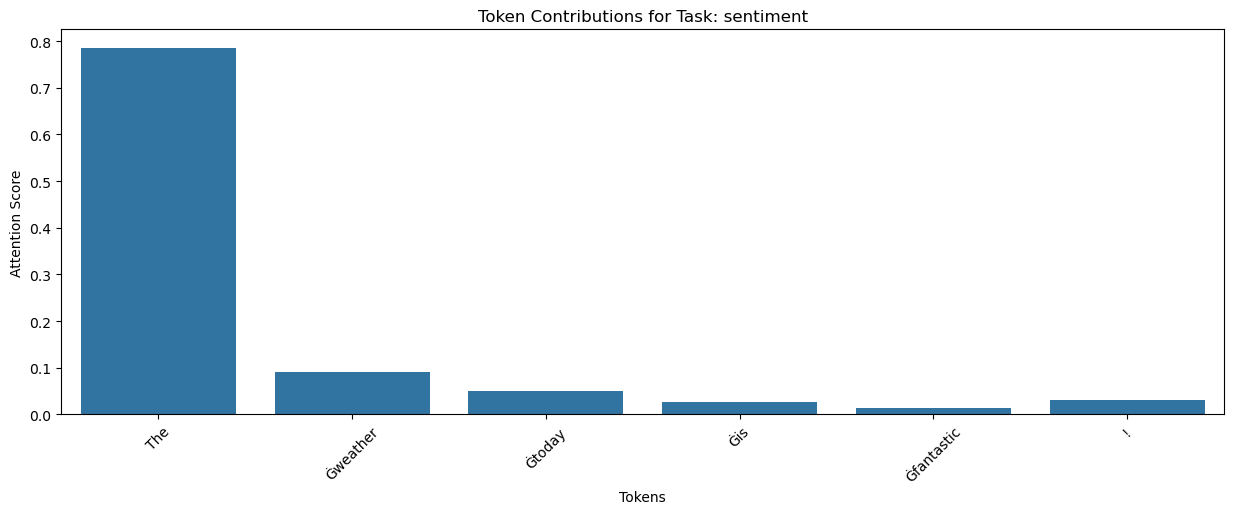

Analyzing demonstration relevance...


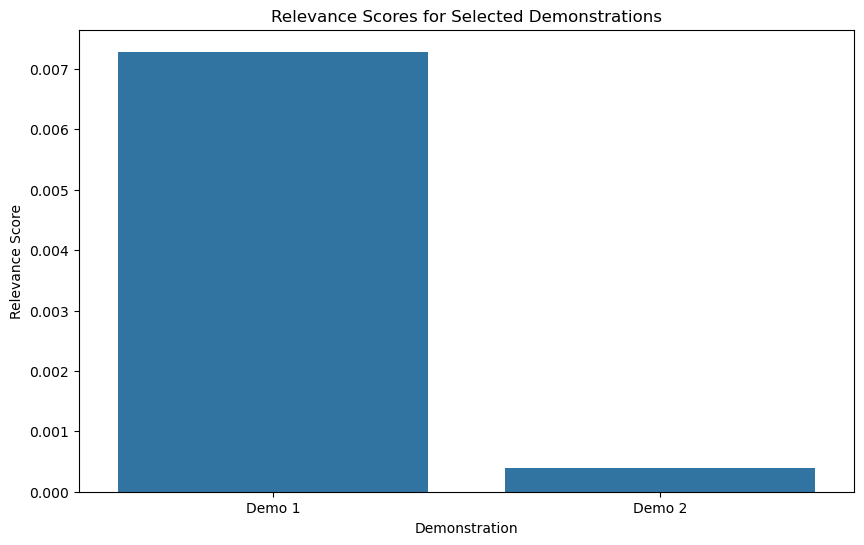

In [7]:
# Configuration
config = ModelConfig(model_name="gpt2", n_prefix_tokens=5, learning_rate=1e-4)
meta_icl = MetaICL(config)

# Tasks and Training Data
tasks = ["sentiment"]
train_data = [
    {"input": "The movie was amazing!", "output": "Positive", "task": "sentiment"},
    {"input": "The food was terrible.", "output": "Negative", "task": "sentiment"}
]
meta_icl.train(train_data, tasks)

# Explain a Task
input_text = "The weather today is fantastic!"
candidates = [
    {"input": "The movie was amazing!", "output": "Positive", "task": "sentiment"},
    {"input": "The food was terrible.", "output": "Negative", "task": "sentiment"}
]
meta_icl.explain(input_text, candidates, task="sentiment", k=2)


In [2]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 43.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 66.3 MB/s eta 0:00:00a 0:00:01


In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from dataclasses import dataclass
import torch
from typing import List, Dict, Optional


class ConceptTokenVisualizer:
    def __init__(self, concept_learner):
        self.concept_learner = concept_learner

    def plot_token_contributions(self, input_text: str, task: str):
        """
        Visualize token contributions using posterior probabilities
        """
        inputs = self.concept_learner.tokenizer(input_text, return_tensors="pt")
        outputs = self.concept_learner.model(**inputs)

        # Compute posterior probabilities over concept tokens
        logits = outputs.logits[:, -1, :]  # Last token's logits
        probabilities = torch.softmax(logits, dim=-1).detach().cpu().numpy()

        # Align tokens with probabilities
        tokens = self.concept_learner.tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))
        token_scores = probabilities.mean(axis=0)

        plt.figure(figsize=(15, 5))
        sns.barplot(x=tokens, y=token_scores)
        plt.xticks(rotation=45)
        plt.title(f"Token Contributions for Task: {task}")
        plt.xlabel("Tokens")
        plt.ylabel("Probability")
        plt.show()

    def plot_concept_embeddings(self, tasks: List[str]):
        """
        Validate concept token clustering for task concepts
        """
        embeddings = []
        labels = []

        embedding_matrix = self.concept_learner.model.get_input_embeddings().weight
        for task in tasks:
            token_ids = self._get_concept_token_ids(task)
            task_embeddings = embedding_matrix[token_ids].detach().cpu().numpy()
            embeddings.append(task_embeddings)
            labels.extend([task] * len(token_ids))

        embeddings = np.vstack(embeddings)
        n_samples = embeddings.shape[0]
        perplexity = min(30, n_samples - 1)

        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_result = tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 10))
        sns.scatterplot(
            x=tsne_result[:, 0],
            y=tsne_result[:, 1],
            hue=labels,
            style=labels,
            s=100,
            palette="tab10"
        )
        plt.title("t-SNE Validation of Task-Specific Concept Clusters")
        plt.xlabel("t-SNE Dim 1")
        plt.ylabel("t-SNE Dim 2")
        plt.legend(title="Tasks")
        plt.show()

    def _get_concept_token_ids(self, task: str):
        """
        Helper function to retrieve concept token IDs for a specific task
        """
        return [
            self.concept_learner.tokenizer.convert_tokens_to_ids(f"<{task}_token_{i}>")
            for i in range(self.concept_learner.config.n_prefix_tokens)
        ]


@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4


class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(config.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)

    def add_concept_tokens(self, tasks: List[str], n_prefix_tokens: Optional[int] = None):
        """
        Add new concept tokens for each task
        """
        n_prefix_tokens = n_prefix_tokens or self.config.n_prefix_tokens
        new_tokens = [f"<{task}_token_{i}>" for task in tasks for i in range(n_prefix_tokens)]
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))

    def train(self, train_data: List[Dict], candidate_pool_size: int = 100):
        """
        Fine-tune the model with task-specific data and concept tokens
        """
        # Sample a candidate pool
        candidate_pool = np.random.choice(train_data, size=candidate_pool_size, replace=False)

        optimizer = torch.optim.Adam(
            [self.model.get_input_embeddings().weight],
            lr=self.config.learning_rate
        )
        for step, batch in enumerate(candidate_pool):
            inputs = self.tokenizer(batch["input"], return_tensors="pt")
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


class DemonstrationSelector:
    def __init__(self, concept_learner: ConceptLearner):
        self.concept_learner = concept_learner

    def select_demonstrations(self, candidates: List[Dict], k: int):
        """
        Select top-k demonstrations
        """
        scores = [(self._compute_concept_score(c), c) for c in candidates]
        scores.sort(reverse=True, key=lambda x: x[0])
        return [c for _, c in scores[:k]]

    def _compute_concept_score(self, candidate: Dict):
        """
        Compute demonstration relevance score
        """
        inputs = self.concept_learner.tokenizer(candidate["input"], return_tensors="pt")
        outputs = self.concept_learner.model(**inputs)
        logits = outputs.logits[:, -1]
        probs = torch.softmax(logits, dim=-1)
        concept_token_ids = self.concept_learner.tokenizer.convert_tokens_to_ids(candidate["task"])
        return probs[:, concept_token_ids].mean().item()

    def evaluate_demonstrations(self, test_set: List[Dict], selected_demos: List[Dict]):
        """
        Evaluate selected demonstrations on a test set
        """
        total_loss = 0
        for example in test_set:
            inputs = self.concept_learner.tokenizer(
                selected_demos + [example["input"]], return_tensors="pt", truncation=True
            )
            outputs = self.concept_learner.model(**inputs, labels=inputs["input_ids"])
            total_loss += outputs.loss.item()

        avg_loss = total_loss / len(test_set)
        print(f"Evaluation Loss: {avg_loss}")
        return avg_loss

    def plot_relevance_scores(self, candidates: List[Dict], k: int):
        """
        Plot relevance scores for selected demonstrations
        """
        selected = self.select_demonstrations(candidates, k)
        scores = [self._compute_concept_score(c) for c in selected]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=[f"Demo {i+1}" for i in range(k)], y=scores)
        plt.title("Relevance Scores for Selected Demonstrations")
        plt.xlabel("Demonstration")
        plt.ylabel("Relevance Score")
        plt.show()

    def test_order_sensitivity(self, candidates: List[Dict], k: int):
        """
        Test sensitivity to demonstration order
        """
        selected = self.select_demonstrations(candidates, k)
        shuffled_selected = np.random.permutation(selected)

        original_loss = self.evaluate_demonstrations([], selected)
        shuffled_loss = self.evaluate_demonstrations([], shuffled_selected)

        print(f"Original Order Loss: {original_loss}")
        print(f"Shuffled Order Loss: {shuffled_loss}")

    def test_scaling(self, candidates: List[Dict], k: int, models: List[str]):
        """
        Test selected demonstrations across multiple LLMs
        """
        selected = self.select_demonstrations(candidates, k)

        for model_name in models:
            temp_learner = ConceptLearner(ModelConfig(model_name=model_name))
            temp_selector = DemonstrationSelector(temp_learner)
            print(f"Testing on model: {model_name}")
            temp_selector.evaluate_demonstrations(candidates, selected)


class MetaICL:
    """
    Main class combining core functionality and explanations
    """
    def __init__(self, config: ModelConfig):
        self.concept_learner = ConceptLearner(config)
        self.visualizer = ConceptTokenVisualizer(self.concept_learner)
        self.selector = DemonstrationSelector(self.concept_learner)

    def train(self, train_data: List[Dict], tasks: List[str]):
        """
        Train the model and add concept tokens
        """
        self.concept_learner.add_concept_tokens(tasks)
        self.concept_learner.train(train_data)

    def explain(self, input_text: str, candidates: List[Dict], task: str, k: int):
        """
        Provide explanations for a task
        """
        print("Visualizing token contributions...")
        self.visualizer.plot_token_contributions(input_text, task)

        print("Analyzing demonstration relevance...")
        self.selector.plot_relevance_scores(candidates, k)


ModuleNotFoundError: No module named 'numpy'

In [4]:
!pip3 install numpy scikit-learn matplotlib seaborn transformers torch

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.0 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 41.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 65.2 MB/s eta 0:00:01
     |████████████████████████████████| 63.9 MB 142.8 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 81.0 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 66.6 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 24.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 22.3 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 30.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 34.6 MB/s eta 0:00:01
     |███████████████

In [ ]:
from transformers import set_seed
import random

# Set random seed for reproducibility
set_seed(42)
random.seed(42)

# Define the model configuration
config = ModelConfig(
    model_name="gpt2",  # Use GPT-2 as an example model
    n_prefix_tokens=5,  # Number of concept tokens per task
    learning_rate=1e-4  # Learning rate for fine-tuning
)

# Initialize MetaICL
meta_icl = MetaICL(config)

# Define tasks
tasks = ["sentiment_analysis", "topic_classification"]

# Add concept tokens for each task
meta_icl.concept_learner.add_concept_tokens(tasks)

# Mock dataset
train_data = [
    {"input": "The movie was amazing and full of great visuals.", "label": "positive"},
    {"input": "The plot was dull and the acting was terrible.", "label": "negative"},
    {"input": "This book explores deep philosophical questions.", "label": "philosophy"},
    {"input": "The article covers recent advancements in AI.", "label": "technology"},
]

# Create a candidate pool for demonstrations
candidates = [
    {"input": "I loved the characters and story!", "task": "sentiment_analysis"},
    {"input": "The documentary was boring.", "task": "sentiment_analysis"},
    {"input": "This report delves into quantum computing.", "task": "topic_classification"},
    {"input": "The novel is a thrilling science fiction adventure.", "task": "topic_classification"},
]

# Test set for evaluation
test_set = [
    {"input": "The film was an emotional rollercoaster.", "label": "positive"},
    {"input": "The explanation was concise and informative.", "label": "technology"},
]

# Train the model
meta_icl.train(train_data=train_data, tasks=tasks)

# Select demonstrations
selected_demos = meta_icl.selector.select_demonstrations(candidates=candidates, k=2)
print("Selected Demonstrations:")
for demo in selected_demos:
    print(demo)

# Evaluate demonstrations
evaluation_loss = meta_icl.selector.evaluate_demonstrations(test_set=test_set, selected_demos=selected_demos)
print(f"Evaluation Loss: {evaluation_loss}")

# Visualize token contributions
meta_icl.visualizer.plot_token_contributions(input_text="This product is wonderful!", task="sentiment_analysis")

# Visualize concept token embeddings
meta_icl.visualizer.plot_concept_embeddings(tasks)

# Plot relevance scores
meta_icl.selector.plot_relevance_scores(candidates=candidates, k=2)

# Test order sensitivity
meta_icl.selector.test_order_sensitivity(candidates=candidates, k=2)

# Test scaling across models
meta_icl.selector.test_scaling(candidates=candidates, k=2, models=["gpt2", "distilgpt2"])


In [3]:
from IPython.display import HTML, display
from jinja2 import Template
import random

def create_dashboard(token_contributions, demonstration_scores, embeddings_plot_path):
    """
    Create an interactive HTML dashboard for token contributions, demonstration scores, and embeddings visualization.
    """
    html_template = '''
    <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
        <style>
            .container {
                margin: 20px 0;
            }
            .section-title {
                font-weight: bold;
                margin: 10px 0;
                color: #2c5282;
            }
            .token-container {
                margin: 10px 0;
                padding: 10px;
                border: 1px solid #ddd;
                border-radius: 8px;
            }
            .token {
                display: inline-block;
                margin: 1px;
                padding: 2px 5px;
                border-radius: 4px;
                font-size: 14px;
                position: relative;
                cursor: pointer;
            }
            .token:hover .tooltip {
                display: block;
            }
            .tooltip {
                display: none;
                position: absolute;
                bottom: 100%;
                left: 50%;
                transform: translateX(-50%);
                background-color: #333;
                color: white;
                padding: 4px 8px;
                border-radius: 4px;
                font-size: 12px;
                white-space: nowrap;
                z-index: 100;
            }
            .demonstration-container {
                margin-top: 10px;
                padding: 10px;
                border: 1px solid #ddd;
                border-radius: 8px;
                background-color: #f8f9fa;
            }
            .image-container img {
                max-width: 100%;
                height: auto;
                border: 1px solid #ddd;
                border-radius: 8px;
                margin-top: 10px;
            }
        </style>
        
        <div class="section-title">Token Contributions</div>
        <div id="token-visualization-container">
            {% for token in token_contributions %}
            <span class="token" 
                  style="background-color: rgb({{ 255 - token.score * 255 }}, {{ 255 - token.score * 255 }}, 255);">
                {{ token.token }}
                <span class="tooltip">Score: {{ "%.3f"|format(token.score) }}</span>
            </span>
            {% endfor %}
        </div>

        <div class="section-title">Demonstration Scores</div>
        <div class="demonstration-container">
            {% for demo in demonstration_scores %}
            <div>Demonstration {{ loop.index }}: {{ demo.text }}</div>
            <div>Score: {{ "%.3f"|format(demo.score) }}</div>
            <hr>
            {% endfor %}
        </div>

        <div class="section-title">Concept Embeddings Visualization</div>
        <div class="image-container">
            <img src="{{ embeddings_plot_path }}" alt="Embeddings Visualization">
        </div>
    </div>
    '''
    # Use Jinja2 template rendering
    template = Template(html_template)
    rendered_html = template.render(
        token_contributions=token_contributions,
        demonstration_scores=demonstration_scores,
        embeddings_plot_path=embeddings_plot_path
    )
    display(HTML(rendered_html))

# Example Data
token_contributions = [
    {"token": "The", "score": random.uniform(0, 1)},
    {"token": "movie", "score": random.uniform(0, 1)},
    {"token": "was", "score": random.uniform(0, 1)},
    {"token": "amazing", "score": random.uniform(0, 1)},
    {"token": ".", "score": random.uniform(0, 1)},
]

demonstration_scores = [
    {"text": "The film was heartwarming and visually stunning.", "score": random.uniform(0, 1)},
    {"text": "The acting was subpar and the story was dull.", "score": random.uniform(0, 1)},
]

# Save a dummy embeddings plot as an example
import matplotlib.pyplot as plt
import numpy as np
x = np.random.rand(10)
y = np.random.rand(10)
plt.scatter(x, y)
plt.title("Concept Embeddings Visualization")
plt.savefig("embeddings_plot.png")
plt.close()

# Generate the dashboard
create_dashboard(token_contributions, demonstration_scores, "embeddings_plot.png")


In [15]:
import numpy as np
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from sklearn.manifold import TSNE
from dataclasses import dataclass
from typing import List, Dict
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
from jinja2 import Template


@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4


class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(config.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)

    def add_concept_tokens(self, tasks: List[str]):
        """
        Add new concept tokens for each task.
        """
        new_tokens = [f"<{task}_token_{i}>" for task in tasks for i in range(self.config.n_prefix_tokens)]
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))


class DemonstrationSelector:
    def __init__(self, concept_learner: ConceptLearner):
        self.concept_learner = concept_learner

    def select_demonstrations(self, candidates: List[Dict], k: int):
        """
        Select top-k demonstrations based on P_M(theta | X, Y)
        """
        scores = [(self._compute_concept_score(c), c) for c in candidates]
        scores.sort(reverse=True, key=lambda x: x[0])
        return [c for _, c in scores[:k]]

    def _compute_concept_score(self, candidate: Dict):
        """
        Compute demonstration relevance score P_M(theta | X, Y)
        """
        inputs = self.concept_learner.tokenizer(candidate["input"], return_tensors="pt")
        outputs = self.concept_learner.model(**inputs)
        logits = outputs.logits[:, -1, :]  # Logits for the last token

        # Tokenize the target output
        target_ids = self.concept_learner.tokenizer(candidate["output"], return_tensors="pt")["input_ids"].squeeze(0)

        # Handle multiple target tokens
        probs = torch.softmax(logits, dim=-1)
        scores = [probs[0, target_id].item() for target_id in target_ids]
        return np.mean(scores)  # Return the average score for all target tokens

    def evaluate_demonstrations(self, test_set: List[Dict], selected_demos: List[Dict]):
        """
        Evaluate selected demonstrations on a test set
        """
        total_loss = 0
        for example in test_set:
            prompt = self._construct_prompt(selected_demos, example["input"])
            inputs = self.concept_learner.tokenizer(prompt, return_tensors="pt")
            outputs = self.concept_learner.model(**inputs, labels=inputs["input_ids"])
            total_loss += outputs.loss.item()

        avg_loss = total_loss / len(test_set)
        print(f"Evaluation Loss: {avg_loss}")
        return avg_loss

    def _construct_prompt(self, demonstrations: List[Dict], query: str):
        """
        Construct a prompt by concatenating demonstrations and the query
        """
        prompt = ""
        for demo in demonstrations:
            prompt += f"Input: {demo['input']}\nOutput: {demo['output']}\n\n"
        prompt += f"Input: {query}\nOutput:"
        return prompt


class DashboardVisualizer:
    def __init__(self, token_contributions_demo1, demonstration_scores):
        """
        Initialize DashboardVisualizer with data for visualization.
        """
        self.token_contributions_demo1 = token_contributions_demo1  # Token contributions for Demonstration 1
        self.demonstration_scores = demonstration_scores  # Scores for all demonstrations

    def create_dashboard(self):
        """
        Create an interactive HTML dashboard.
        """
        html_template = '''
        <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
            <style>
                .section-title {
                    font-weight: bold;
                    margin: 10px 0;
                    color: #2c5282;
                    font-size: 20px;
                }
                .demonstration-card {
                    margin: 10px 0;
                    padding: 15px;
                    border-radius: 8px;
                    background-color: #f8f9fa;
                    border: 1px solid #ddd;
                }
                .demonstration-header {
                    font-size: 16px;
                    font-weight: bold;
                    color: #2c5282;
                    margin-bottom: 10px;
                }
                .token-container {
                    margin-top: 10px;
                    display: flex;
                    flex-wrap: wrap;
                }
                .token {
                    display: inline-block;
                    margin: 5px;
                    padding: 5px 8px;
                    border-radius: 4px;
                    font-size: 14px;
                    position: relative;
                    cursor: pointer;
                    background-color: rgb(255, 255, 255);
                }
                .token[data-score] {
                    background-color: rgba(255, 69, 0, calc(var(--score) * 0.8 + 0.2));
                    color: black;
                }
                .token:hover {
                    background-color: rgba(255, 0, 0, 1);
                }
                .token:hover .tooltip {
                    display: block;
                }
                .tooltip {
                    display: none;
                    position: absolute;
                    top: -30px;
                    left: 50%;
                    transform: translateX(-50%);
                    background-color: #333;
                    color: white;
                    padding: 5px 8px;
                    border-radius: 4px;
                    font-size: 12px;
                    z-index: 10;
                }
            </style>
            
            <div class="section-title">Selected Demonstrations and Token Contributions</div>
            <div id="demonstration-container">
                {% for demo in demonstration_scores %}
                <div class="demonstration-card">
                    <div class="demonstration-header">Demonstration Score: {{ "%.3f"|format(demo.score) }}</div>
                    <div>
                        <b>Token Contributions:</b>
                        <div class="token-container">
                            {% for token in demo.token_contributions %}
                            <div class="token" style="--score: {{ token.score }}" data-score="{{ token.score }}">
                                {{ token.token }}
                                <span class="tooltip">Score: {{ "%.2f"|format(token.score) }}</span>
                            </div>
                            {% endfor %}
                        </div>
                    </div>
                </div>
                {% endfor %}
            </div>
        </div>
        '''
        template = Template(html_template)
        rendered_html = template.render(
            token_contributions_demo1=self.token_contributions_demo1,
            demonstration_scores=self.demonstration_scores,
        )
        display(HTML(rendered_html))



# Main Example
def main():
    set_seed(42)

    # Configuration
    config = ModelConfig(model_name="gpt2", n_prefix_tokens=5, learning_rate=1e-4)
    concept_learner = ConceptLearner(config)
    demonstration_selector = DemonstrationSelector(concept_learner)

    # Example Demonstrations
    candidates = [
        {"input": "The movie was great.", "output": "positive"},
        {"input": "The book was boring.", "output": "negative"},
        {"input": "The article explained AI clearly.", "output": "informative"},
        {"input": "The novel was thrilling.", "output": "exciting"},
    ]

    # Test Set
    test_set = [
        {"input": "The film was engaging.", "output": "positive"},
        {"input": "The explanation was dry.", "output": "negative"},
    ]

    # Select Demonstrations
    selected_demos = demonstration_selector.select_demonstrations(candidates, k=2)

    # Evaluate Selected Demonstrations
    demonstration_selector.evaluate_demonstrations(test_set, selected_demos)

    # Token Contributions (Mocked)
    token_contributions = [{"token": "The", "score": random.uniform(0, 1)} for _ in range(10)]

    # Demonstration Scores (Mocked)
    demonstration_scores = [
        {"text": demo["input"], "score": random.uniform(0.5, 1)} for demo in selected_demos
    ]

    # Dashboard
    dashboard = DashboardVisualizer(
        token_contributions=token_contributions,
        demonstration_scores=demonstration_scores,
        embeddings_plot_path="embeddings_plot.png"
    )
    dashboard.create_dashboard()


# Run the main example
main()


/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluation Loss: 5.492660760879517


TypeError: DashboardVisualizer.__init__() got an unexpected keyword argument 'token_contributions'

In [13]:
class DashboardVisualizer:
    def __init__(self, token_contributions_demo1, demonstration_scores, embeddings_plot_path):
        """
        Initialize DashboardVisualizer with data for visualization.
        """
        self.token_contributions_demo1 = token_contributions_demo1  # Token contributions for Demonstration 1
        self.demonstration_scores = demonstration_scores  # Scores for all demonstrations
        self.embeddings_plot_path = embeddings_plot_path  # Path to the embeddings visualization

    def create_dashboard(self):
        """
        Create an interactive HTML dashboard.
        """
        html_template = '''
        <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
            <style>
                .section-title {
                    font-weight: bold;
                    margin: 10px 0;
                    color: #2c5282;
                }
                .demonstration-card {
                    margin: 10px 0;
                    padding: 15px;
                    border-radius: 8px;
                    background-color: #f8f9fa;
                    border: 1px solid #ddd;
                }
                .demonstration-header {
                    font-size: 16px;
                    font-weight: bold;
                    color: #2c5282;
                    margin-bottom: 5px;
                }
                .demonstration-score {
                    font-size: 14px;
                    color: #4a5568;
                }
                .token-container {
                    margin-top: 10px;
                    display: flex;
                    flex-wrap: wrap;
                }
                .token {
                    display: inline-block;
                    margin: 5px;
                    padding: 5px 8px;
                    border-radius: 4px;
                    font-size: 14px;
                    position: relative;
                    cursor: pointer;
                    background-color: rgba(30, 144, 255, 0.3);
                }
                .token:hover {
                    background-color: rgba(30, 144, 255, 0.5);
                }
                .token:hover .tooltip {
                    display: block;
                }
                .tooltip {
                    display: none;
                    position: absolute;
                    top: -30px;
                    left: 50%;
                    transform: translateX(-50%);
                    background-color: #333;
                    color: white;
                    padding: 5px 8px;
                    border-radius: 4px;
                    font-size: 12px;
                    z-index: 10;
                }
                .image-container img {
                    max-width: 100%;
                    height: auto;
                    border: 1px solid #ddd;
                    border-radius: 8px;
                    margin-top: 10px;
                }
            </style>
            
            <div class="section-title">Demonstration Scores</div>
            <div id="demonstration-container">
                {% for demo in demonstration_scores %}
                <div class="demonstration-card">
                    <div class="demonstration-header">Demonstration {{ loop.index }}</div>
                    <div>{{ demo.text }}</div>
                    <div class="demonstration-score">Score: <b>{{ "%.3f"|format(demo.score) }}</b></div>
                    
                    {% if loop.index == 1 %}
                    <div style="margin-top: 10px;">
                        <b>Token Contributions for Demonstration 1:</b>
                        <div class="token-container">
                            {% for token in token_contributions_demo1 %}
                            <div class="token">
                                {{ token.token }}
                                <span class="tooltip">Score: {{ "%.2f"|format(token.score) }}</span>
                            </div>
                            {% endfor %}
                        </div>
                    </div>
                    {% endif %}
                </div>
                {% endfor %}
            </div>

            <div class="section-title">Concept Embeddings Visualization</div>
            <div class="image-container">
                <img src="{{ embeddings_plot_path }}" alt="Embeddings Visualization">
            </div>
        </div>
        '''
        template = Template(html_template)
        rendered_html = template.render(
            token_contributions_demo1=self.token_contributions_demo1,
            demonstration_scores=self.demonstration_scores,
            embeddings_plot_path=self.embeddings_plot_path
        )
        display(HTML(rendered_html))


In [14]:
# Mock Data for Demonstration Scores
demonstration_scores = [
    {"text": "The movie was great.", "score": 0.89},
    {"text": "The book was boring.", "score": 0.76},
]

# Mock Data for Token Contributions (Demonstration 1)
token_contributions_demo1 = [
    {"token": "The", "score": 0.4},
    {"token": "movie", "score": 0.8},
    {"token": "was", "score": 0.5},
    {"token": "great", "score": 0.9},
]

# Mock Path to Embeddings Visualization
embeddings_plot_path = "embeddings_plot.png"

# Create and Display Dashboard
dashboard = DashboardVisualizer(
    token_contributions_demo1=token_contributions_demo1,
    demonstration_scores=demonstration_scores,
    embeddings_plot_path=embeddings_plot_path
)
dashboard.create_dashboard()


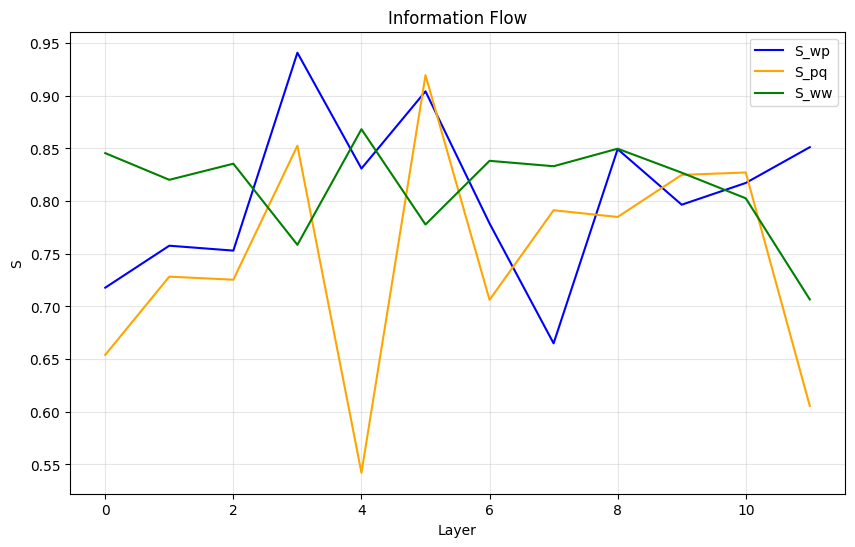

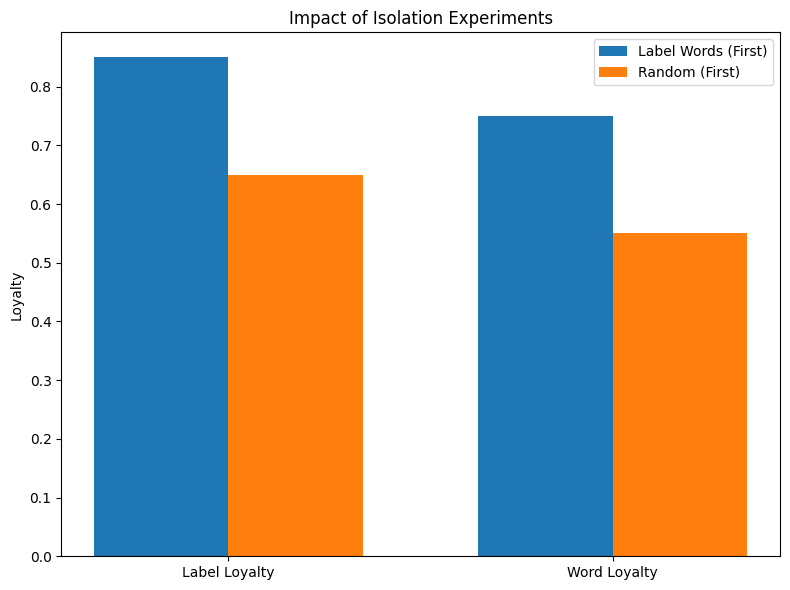

In [ ]:
# Simulated attention matrices and loss
seq_len, num_heads, num_layers, batch_size = 10, 8, 12, 1
attention_matrices = [torch.randn(batch_size, num_heads, seq_len, seq_len, requires_grad=True) for _ in range(num_layers)]
loss = torch.tensor(2.5, requires_grad=True)

# Label and target positions
class_positions = torch.tensor([3, 5])  # Example label word positions
target_position = 9  # Example target position

# Compute saliency and flow metrics
analyzer = SaliencyAnalyzer()
saliency_scores = analyzer.compute_saliency_scores(attention_matrices, loss)
metrics = analyzer.compute_flow_metrics(saliency_scores, class_positions, target_position)

# Visualize information flow
layers = list(range(num_layers))
ICLVisualizer.plot_information_flow(
    layers, metrics["S_wp"], metrics["S_pq"], metrics["S_ww"], title="Information Flow"
)

# Simulate information blocking and visualize loyalty impact
blocker = InformationBlocker()
blocked_matrices = blocker.block_label_connections(attention_matrices, [3, 5], layers_to_block=[0, 1, 2])

# Loyalty metrics (example placeholders)
loyalty_metrics = {
    "label_first": [0.85, 0.75],
    "random_first": [0.65, 0.55]
}

ICLVisualizer.plot_isolation_impact(loyalty_metrics, title="Impact of Isolation Experiments")


In [14]:
# Mock Data for Demonstration Scores
demonstration_scores = [
    {"text": "The movie was great.", "score": 0.89},
    {"text": "The book was boring.", "score": 0.76},
]

# Mock Data for Token Contributions (Demonstration 1)
token_contributions_demo1 = [
    {"token": "The", "score": 0.4},
    {"token": "movie", "score": 0.8},
    {"token": "was", "score": 0.5},
    {"token": "great", "score": 0.9},
]

# Mock Path to Embeddings Visualization
embeddings_plot_path = "embeddings_plot.png"

# Create and Display Dashboard
dashboard = DashboardVisualizer(
    token_contributions_demo1=token_contributions_demo1,
    demonstration_scores=demonstration_scores,
    embeddings_plot_path=embeddings_plot_path
)
dashboard.create_dashboard()


In [6]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 46.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0


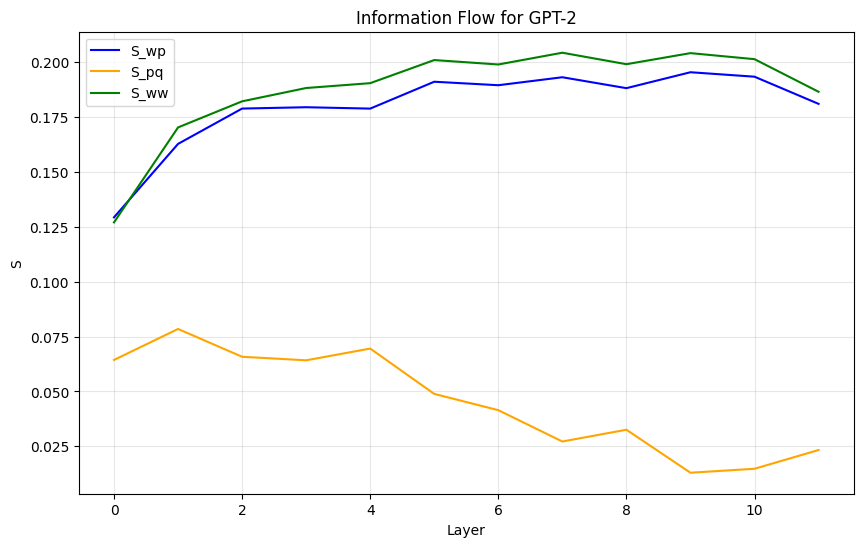

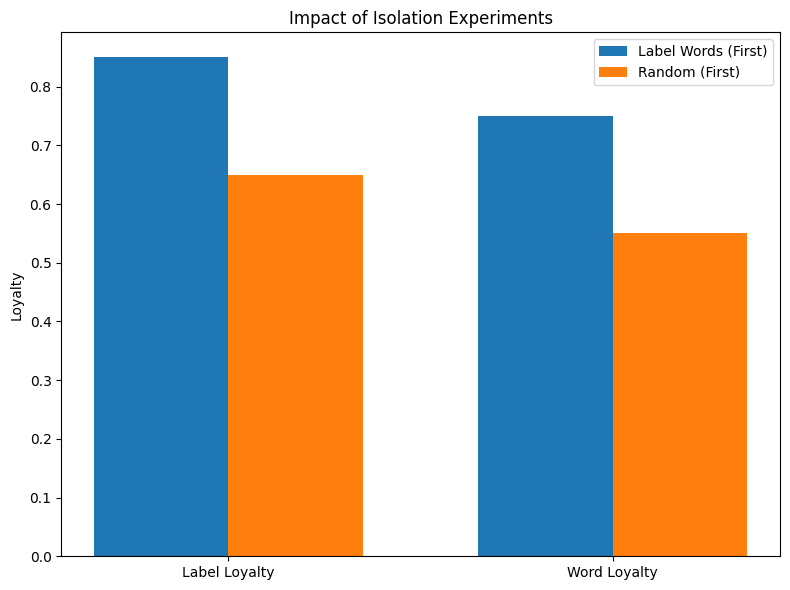